## 1. Знакомство с данными, базовый анализ и расширение данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML 

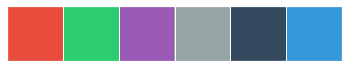

In [2]:
# Настройка цветовой гаммы 
sns.set_theme(style = "darkgrid")
clrmap = ["#e74c3c","#2ecc71","#9b59b6", "#95a5a6", "#34495e","#3498db"]
sns.set_palette(clrmap)
sns.palplot(sns.color_palette())

In [3]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


У нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Для начала посмотрим на временные рамки, в которых мы работаем с данными.
Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print('Время начала первой поездки: ', taxi_data['pickup_datetime'].min().date())
print('Время начала последней поездки: ', taxi_data['pickup_datetime'].max().date())

Время начала первой поездки:  2016-01-01
Время начала последней поездки:  2016-06-30


Посмотрим на пропуски. 

In [5]:
print('Всего пропущенных значений: ', taxi_data.isnull().sum().sum())

Всего пропущенных значений:  0


Посмотрим на статистические характеристики некоторых признаков. 

In [6]:
print('а) Количество уникальных таксопарков: ', taxi_data.vendor_id.nunique())
print('б) Максимальное количество пассажиров: ', taxi_data.passenger_count.max())
print('в) Средняя длительность поездки: ', round(taxi_data.trip_duration.mean()))
print('   Медианная длительность поездки: ', round(taxi_data.trip_duration.median()))
print('г) Минимальная длительность поездки: ', taxi_data.trip_duration.min())
print('   Максимальная длительность поездки: ', taxi_data.trip_duration.max())

а) Количество уникальных таксопарков:  2
б) Максимальное количество пассажиров:  9
в) Средняя длительность поездки:  959
   Медианная длительность поездки:  662
г) Минимальная длительность поездки:  1
   Максимальная длительность поездки:  3526282



Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [7]:
def add_datetime_features(data):
    data['pickup_date'] = data['pickup_datetime'].dt.date
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['pickup_day_of_week'] = data['pickup_datetime'].dt.day_name()
    return data

taxi_data = add_datetime_features(taxi_data)

saturday_count = taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0]
trip_count_mean = taxi_data.shape[0]/taxi_data['pickup_date'].nunique()

print('а) Количество поездок в субботу: ', saturday_count)
print('б) Максимальное количество пассажиров: ', round(trip_count_mean))

а) Количество поездок в субботу:  220868
б) Максимальное количество пассажиров:  8015


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [8]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

def add_holiday_features(data, holidays):
    holidays['date'] = pd.to_datetime(holidays['date']).dt.date
    data = data.merge(holidays, left_on='pickup_date', right_on = 'date', how = 'left')
    data['holiday'] = data['holiday'].fillna(0)
    data['pickup_holiday'] = data['holiday'].apply(lambda x: 0 if x == 0 else 1)
    data = data.drop(holidays.columns, axis = 1)
    return data

taxi_data = add_holiday_features(taxi_data, holiday_data)

holiday_trip_duration_median = taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median()
print('Медианная длительность поездки на такси в праздничные дни: ', round(holiday_trip_duration_median))

Медианная длительность поездки на такси в праздничные дни:  585


Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [9]:
osrm_data = pd.read_csv('osrm_data_train.csv')

def add_osrm_features(data, osrm):
    columns = ['id','total_distance','total_travel_time', 'number_of_steps']
    data = data.merge(osrm[columns], on='id', how = 'left')
    return data

taxi_data = add_osrm_features(taxi_data, osrm_data)

time_difference = taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()
print('а) Разница между медианной длительностью поездки в данных и в OSRM: ', round(time_difference))

nulls = taxi_data.isnull().sum()
print('б) Пропуски после объединения таблиц:')
display (nulls[nulls>0])

а) Разница между медианной длительностью поездки в данных и в OSRM:  372
б) Пропуски после объединения таблиц:


total_distance       1
total_travel_time    1
number_of_steps      1
dtype: int64

In [10]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [11]:
def add_geographical_features(data):
    data ['haversine_distance'] = data.apply(lambda x: get_haversine_distance(x['pickup_latitude'], 
                                                                              x['pickup_longitude'], 
                                                                              x['dropoff_latitude'],
                                                                              x['dropoff_longitude']), 
                                                                              axis=1)
    data ['direction'] = data.apply(lambda x: get_angle_direction(x['pickup_latitude'], 
                                                                  x['pickup_longitude'], 
                                                                  x['dropoff_latitude'],
                                                                  x['dropoff_longitude']), 
                                                                  axis=1)  
    return data

taxi_data = add_geographical_features(taxi_data)

print('Медианное расстояние Хаверсина (км): ', round(taxi_data['haversine_distance'].median(), 2))

Медианное расстояние Хаверсина (км):  2.09


Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [12]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(data, cluster):
    coords = data[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']]
    predictions = cluster.predict(coords)
    predictions = cluster.labels_
    data ['geo_cluster'] = predictions
    return data

taxi_data = add_cluster_features(taxi_data, kmeans)

smallest_cluster_trip_count = taxi_data[taxi_data['geo_cluster'] == taxi_data['geo_cluster'].value_counts().iloc[-1]].shape[0]
print(f'В наименьшем по размеру географическом кластере содержится {smallest_cluster_trip_count} поездки')

В наименьшем по размеру географическом кластере содержится 2 поездки


Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [13]:
weather_data = pd.read_csv('weather_data.csv')

def add_weather_features(data, weather):
    weather['time'] = pd.to_datetime(weather['time'], format='%Y-%m-%d %H:%M:%S')
    weather['pickup_date'] = weather['time'].dt.date
    weather['pickup_hour'] = weather['time'].dt.hour
    columns = ['pickup_date','pickup_hour','temperature','visibility','wind speed','precip','events']
    data = data.merge(weather[columns], on=['pickup_date', 'pickup_hour'], how = 'left')
    return data 

taxi_data = add_weather_features(taxi_data, weather_data)

print('а) Количество поездок, совершенных в снежную погоду: ', taxi_data[taxi_data['events']=='Snow'].shape[0])

nulls = taxi_data.isnull().sum()
display (nulls[nulls>0])
null_percent = round(taxi_data.isnull().sum().loc['events']/taxi_data.shape[0]*100, 2)
print(f'б) Процент пропусков в столбцах с погодными условиями: {null_percent} %')

а) Количество поездок, совершенных в снежную погоду:  13126


total_distance           1
total_travel_time        1
number_of_steps          1
temperature          12032
visibility           12032
wind speed           12032
precip               12032
events               12032
dtype: int64

б) Процент пропусков в столбцах с погодными условиями: 0.82 %


Реализуем функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 


In [14]:
def fill_null_weather_data(data): 
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_columns:
        data[col] = data[col].fillna(data.groupby('pickup_date')[col].transform('median'))

    data['events'] = data['events'].fillna('None')
    
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    for col in osrm_columns:
        data[col] = data[col].fillna(data[col].median())
        
    return data

taxi_data = fill_null_weather_data(taxi_data)

print(f'Медиана в столбце temperature после заполнения пропусков: {taxi_data.temperature.median()}')

Медиана в столбце temperature после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что будем считать выбросами только последнюю группу. 

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислим среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Построим диаграмму рассеяния средней скорости движения автомобилей


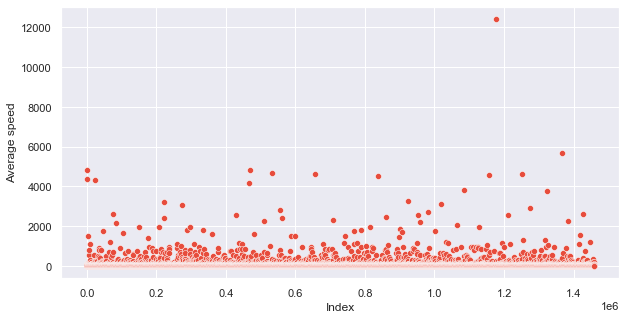

In [15]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Отсюда мы видим, что есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч.
Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Найдем поездки, длительность которых превышает 24 часа. И удалим их из набора данных.

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалим их из данных. 

In [16]:
print('а) Количество поездок длительностью более 24 ч: ', taxi_data[taxi_data['trip_duration'] > 60*60*24].shape[0])

taxi_data['avg_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
print('б) Количество поездок со скоростю более 300 км/ч: ', taxi_data[taxi_data['avg_speed'] > 300].shape[0])

taxi_data = taxi_data[taxi_data['trip_duration'] <= 60*60*24]
taxi_data = taxi_data[taxi_data['avg_speed'] <= 300]

а) Количество поездок длительностью более 24 ч:  4
б) Количество поездок со скоростю более 300 км/ч:  407


## 2. Разведывательный анализ данных (EDA)

Начинаем с целевого признака. Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1)$$


In [17]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделаем предположение, является ли полученное распределение нормальным.
Проверим свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

p=0.000
Данные не распределены нормально


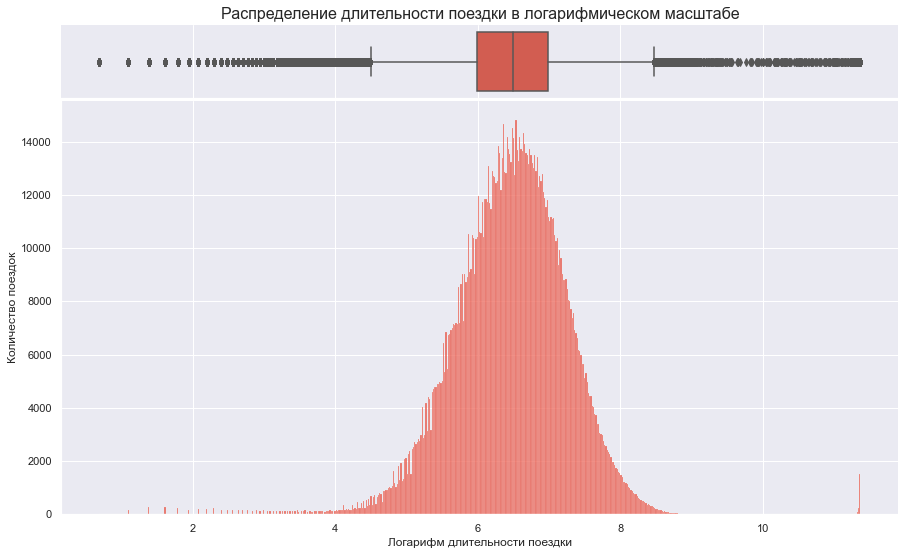

In [18]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально'

alpha = 0.05

_, p = normaltest(taxi_data['trip_duration_log'])
print('p=%.3f' % p)

if p > alpha/2:
    print(H0)
else:
    print(Ha)

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize = (15, 9),
                                    gridspec_kw={"height_ratios": (.15, .85)})

plt.subplots_adjust(hspace = 0.01)

sns.boxplot(taxi_data['trip_duration_log'], ax=ax_box)
sns.histplot(taxi_data['trip_duration_log'], ax=ax_hist)
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
ax_box.set_title('Распределение длительности поездки в логарифмическом масштабе', fontsize = 16);
ax_hist.set_xlabel('Логарифм длительности поездки');
ax_hist.set_ylabel('Количество поездок');

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

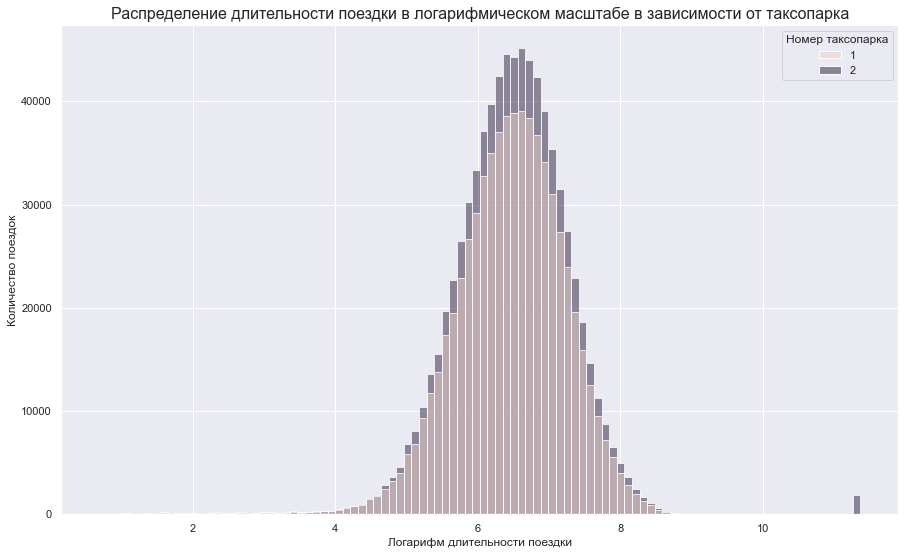

In [19]:
fig = plt.figure(figsize = (15, 9));
histplot = sns.histplot(taxi_data, x='trip_duration_log', hue='vendor_id', bins = 100)
histplot.set_title('Распределение длительности поездки в логарифмическом масштабе в зависимости от таксопарка', fontsize = 16);
histplot.set_xlabel('Логарифм длительности поездки');
histplot.set_ylabel('Количество поездок');
legend = histplot.get_legend()
handles = legend.legendHandles
legend.remove()
histplot.legend(handles, ['1', '2'], title='Номер таксопарка')
plt.show() 

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

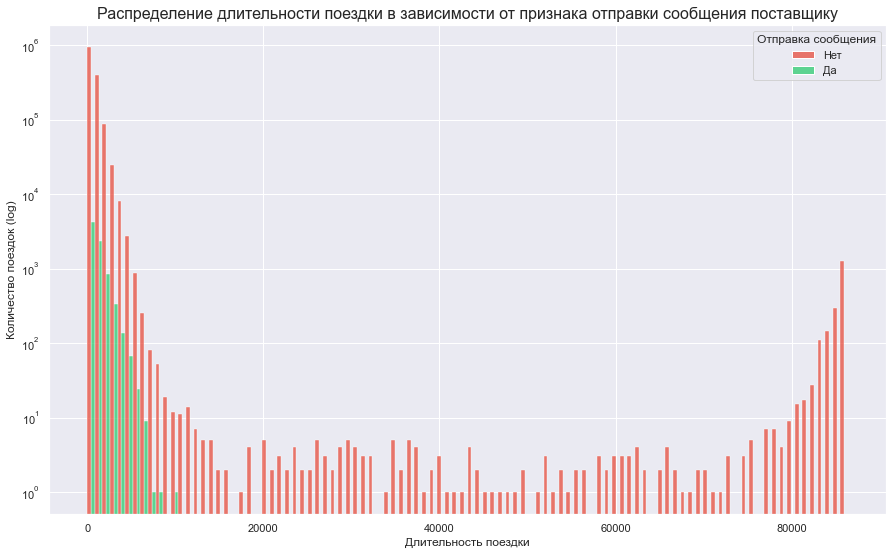

In [20]:
fig = plt.figure(figsize = (15, 9));
histplot = sns.histplot(taxi_data, x='trip_duration', hue='store_and_fwd_flag', multiple='dodge', log_scale=(False, True), bins = 100)
histplot.set_title('Распределение длительности поездки в зависимости от признака отправки сообщения поставщику', fontsize = 16);
histplot.set_xlabel('Длительность поездки');
histplot.set_ylabel('Количество поездок (log)');
legend = histplot.get_legend()
handles = legend.legendHandles
legend.remove()
histplot.legend(handles, ['Нет', 'Да'], title='Отправка сообщения')
plt.show() 

Построимдве визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

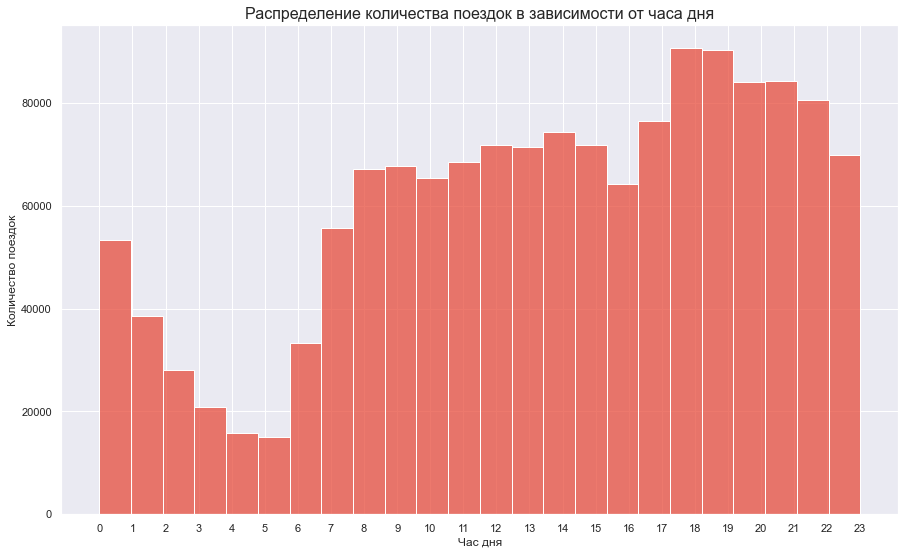

а) Реже всего такси заказывают с 0:00 до 6:00


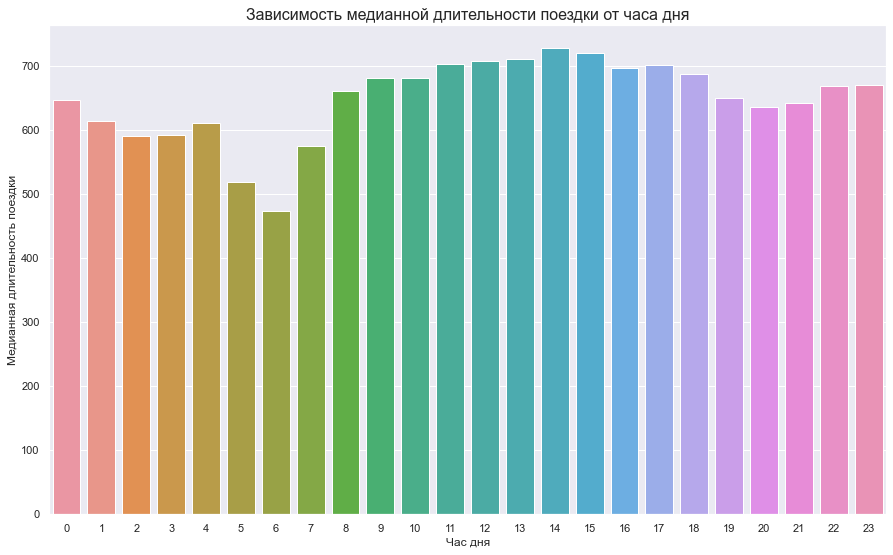

б) Пик медианной длительности поездок наблюдается с 13:00 до 15:00


In [21]:
fig = plt.figure(figsize = (15, 9))

histplot = sns.histplot(
    data = taxi_data,
    x = 'pickup_hour',
    bins = 24,
    );
histplot.set_title('Распределение количества поездок в зависимости от часа дня', fontsize = 16);
histplot.set_xlabel('Час дня');
histplot.set_ylabel('Количество поездок');
histplot.set_xticks(range(0, 24, 1));

plt.show()
print ('а) Реже всего такси заказывают с 0:00 до 6:00')
bar_data = taxi_data.groupby(by = 'pickup_hour', as_index = False)['trip_duration'].median()
fig = plt.figure(figsize = (15, 9));

barplot = sns.barplot(data = bar_data, x = 'pickup_hour', y = 'trip_duration');
barplot.set_ylabel('Медианная длительность поездки');
barplot.set_xlabel('Час дня');
barplot.set_title('Зависимость медианной длительности поездки от часа дня', fontsize = 16);

plt.show()
print ('б) Пик медианной длительности поездок наблюдается с 13:00 до 15:00')

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
* Зависимость медианной длительности поездки от дня недели.

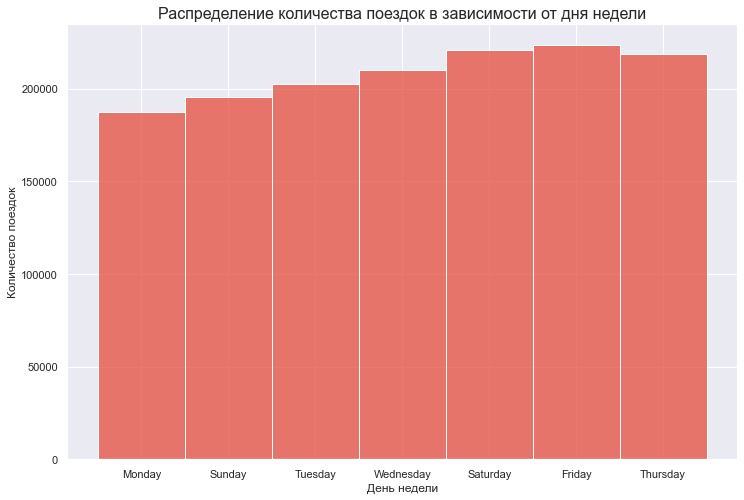

а) Больше всего поездок совершается в пятницу


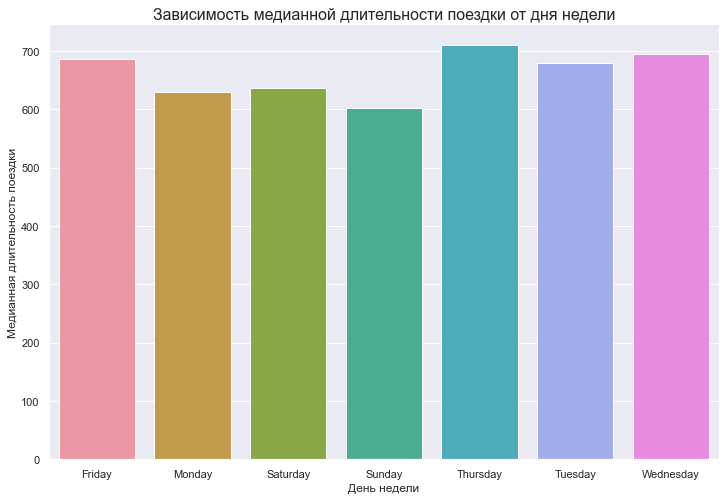

б) В воскресенье медианная длительность поездок наименьшая


In [22]:
fig = plt.figure(figsize = (12, 8))

histplot = sns.histplot(
    data = taxi_data,
    x = 'pickup_day_of_week',
    bins = 7,
    );
histplot.set_title('Распределение количества поездок в зависимости от дня недели', fontsize = 16);
histplot.set_xlabel('День недели');
histplot.set_ylabel('Количество поездок');
#histplot.set_xticks(range(0, 24, 1));

plt.show()
print ('а) Больше всего поездок совершается в пятницу')
bar_data = taxi_data.groupby(by = 'pickup_day_of_week', as_index = False)['trip_duration'].median()
fig = plt.figure(figsize = (12, 8));

barplot = sns.barplot(data = bar_data, x = 'pickup_day_of_week', y = 'trip_duration');
barplot.set_ylabel('Медианная длительность поездки');
barplot.set_xlabel('День недели');
barplot.set_title('Зависимость медианной длительности поездки от дня недели', fontsize = 16);

plt.show()
print ('б) В воскресенье медианная длительность поездок наименьшая')

Посмотрим на обе временные характеристики одновременно. 

Постройим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

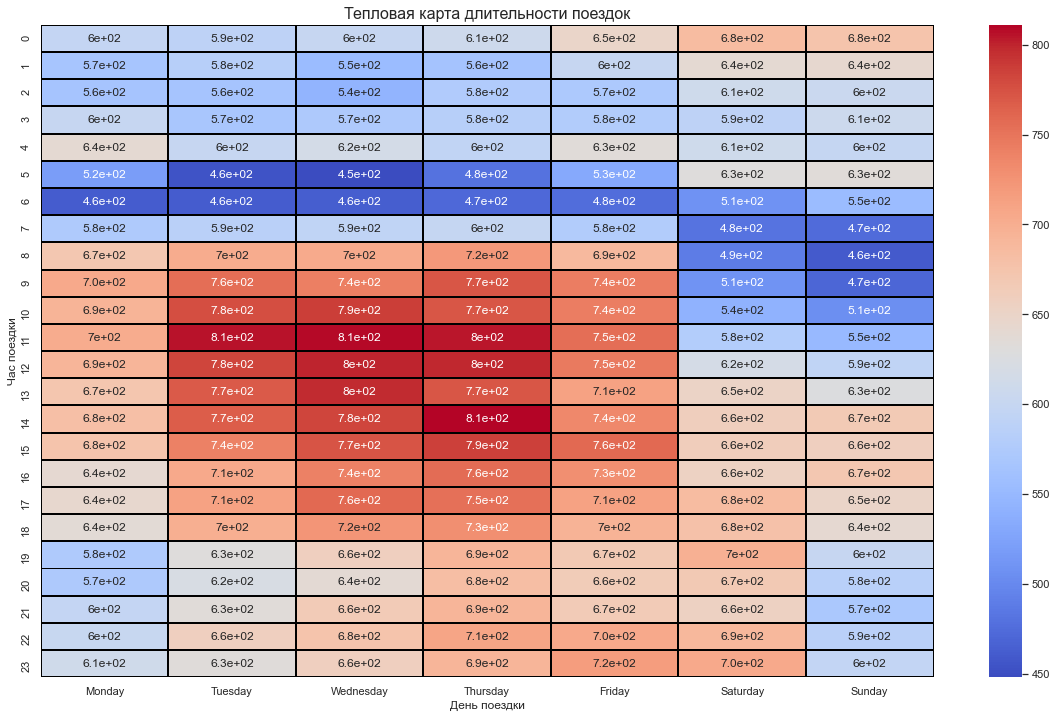

In [23]:
pivot = taxi_data.pivot_table(
    values = 'trip_duration',
    index = 'pickup_hour',
    columns = 'pickup_day_of_week',
    aggfunc = 'median',
    )
pivot = pivot[['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday', 'Sunday']]

fig = plt.figure(figsize = (20, 12));

heatmap = sns.heatmap(pivot, annot = True, cmap = 'coolwarm', linewidths = 1, linecolor = 'black');
heatmap.set_title('Тепловая карта длительности поездок', fontsize = 16);
heatmap.set_xlabel('День поездки');
heatmap.set_ylabel('Час поездки');

plt.show()

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

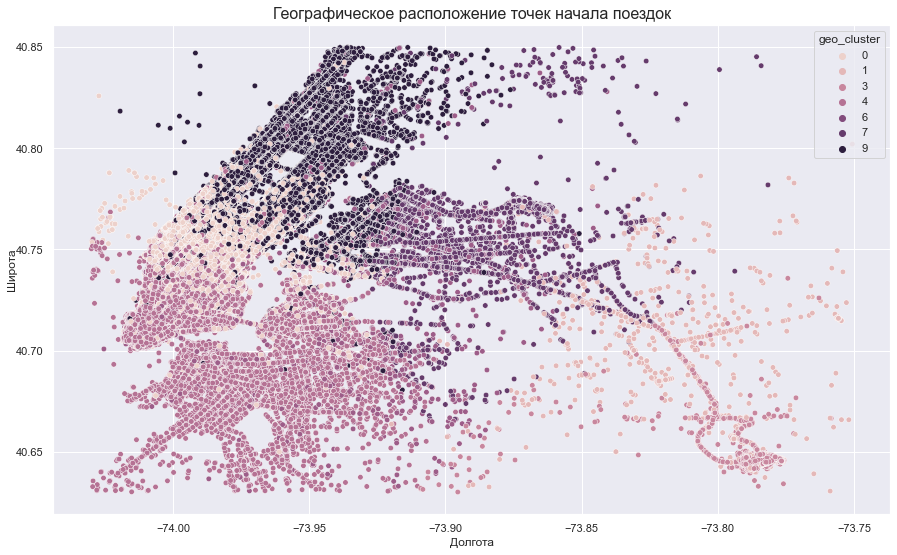

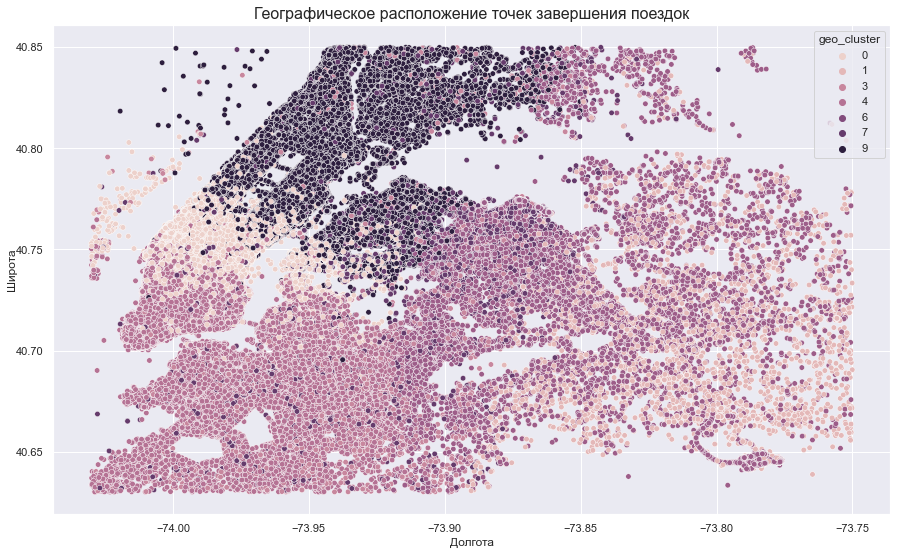

In [24]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

mask_1 = (taxi_data['pickup_latitude'] >= city_lat_border[0]) & (taxi_data['pickup_latitude'] <= city_lat_border[1])
mask_2 = (taxi_data['pickup_longitude'] >= city_long_border[0]) & (taxi_data['pickup_longitude'] <= city_long_border[1])
pickup_scatter_data = taxi_data [mask_1 & mask_2]

fig = plt.figure(figsize = (15, 9));
scatterplot = sns.scatterplot(data = pickup_scatter_data, 
                              x = 'pickup_longitude', 
                              y = 'pickup_latitude', 
                              s = 30,
                              hue = 'geo_cluster'
                             );
scatterplot.set_ylabel('Широта', va = 'center');
scatterplot.set_title('Географическое расположение точек начала поездок', fontsize = 16);
scatterplot.set_xlabel('Долгота');
plt.show() 

mask_3 = (taxi_data['dropoff_latitude'] > city_lat_border[0]) & (taxi_data['dropoff_latitude'] < city_lat_border[1])
mask_4 = (taxi_data['dropoff_longitude'] > city_long_border[0]) & (taxi_data['dropoff_longitude'] < city_long_border[1])
dropoff_scatter_data = taxi_data [mask_3 & mask_4]

fig = plt.figure(figsize = (15, 9));
scatterplot = sns.scatterplot(data = dropoff_scatter_data, 
                              x = 'dropoff_longitude', 
                              y = 'dropoff_latitude', 
                              s = 30,
                              hue = 'geo_cluster'
                             );
scatterplot.set_ylabel('Широта', va = 'center');
scatterplot.set_title('Географическое расположение точек завершения поездок', fontsize = 16);
scatterplot.set_xlabel('Долгота');
plt.show()

## 3. Отбор и преобразование признаков

In [25]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'avg_speed', 'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [26]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,avg_speed,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,15.896176,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,13.646335,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,18.747119,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,14.932028,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,13.364690,6.077642


In [27]:
train_data = train_data.drop(['id','dropoff_datetime','avg_speed'], axis=1)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [28]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

In [29]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
print('а) Среднее по закодированному столбцу vendor_id: ', round (train_data['vendor_id'].mean(), 2))
print('б) Среднее по закодированному столбцу store_and_fwd_flagу: ', round (train_data['store_and_fwd_flag'].mean(), 3))

а) Среднее по закодированному столбцу vendor_id:  0.53
б) Среднее по закодированному столбцу store_and_fwd_flagу:  0.006


Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, pickup_dropoff_cluster и events в таблице train_data с помощью OneHotEndoder() из библиотеки sklearn.

In [30]:
from sklearn.preprocessing import OneHotEncoder
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = OneHotEncoder(drop = 'first') 
data_onehot = encoder.fit_transform(train_data[columns_to_change]).toarray()
columns = encoder.get_feature_names(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=columns)
print (f'Получилось сгенерировать с помощью кодирования {data_onehot.shape[1]} столбцов')

Получилось сгенерировать с помощью кодирования 18 столбцов


In [31]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [32]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [33]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке, используя параметр score_func = f_regression.

In [34]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
cols = selector.get_support(indices=True)
best_list = list(X_train.iloc[:,cols].columns)
best_list

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'pickup_hour',
 'pickup_holiday',
 'total_distance',
 'total_travel_time',
 'number_of_steps',
 'haversine_distance',
 'temperature',
 'pickup_day_of_week_Monday',
 'pickup_day_of_week_Saturday',
 'pickup_day_of_week_Sunday',
 'pickup_day_of_week_Thursday',
 'pickup_day_of_week_Tuesday',
 'pickup_day_of_week_Wednesday',
 'geo_cluster_1',
 'geo_cluster_3',
 'geo_cluster_5',
 'geo_cluster_7',
 'geo_cluster_9']

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то заранее позаботимся о масштабировании факторов. 


Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. 

In [35]:
X_train = X_train[best_list]
X_valid = X_valid[best_list]

In [36]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=best_list)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=best_list)

## 4. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Логарифмирование целевого признака мы уже провели заранее, поэтому будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии на обучающей выборке.

In [37]:
#Создаём объект класса LinearRegression
lr= linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr.fit(X_train_scaled,  y_train_log)
y_train_predict = lr.predict(X_train_scaled)
y_valid_predict = lr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.54
Test RMSLE score: 0.54


Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. 
Построим модель полиномиальной регрессии 2-ой степени на обучающей выборке.

In [38]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_valid_poly = poly.transform(X_valid_scaled)

lr_model_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_model_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
                  
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict_poly))))

Train RMSLE score: 0.47
Test RMSLE score: 0.70


Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке.

In [39]:
ridge_lr_poly = linear_model.Ridge(alpha=1)
#Обучаем модель
ridge_lr_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_valid_predict_poly = ridge_lr_poly.predict(X_valid_poly)

print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict_poly))))

Train RMSLE score: 0.48
Test RMSLE score: 0.48


Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке.

In [40]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor()
regr.fit(X_train_scaled,  y_train_log)

y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.00
Test RMSLE score: 0.57


Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Построим линейные графики изменения метрики RMSLE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

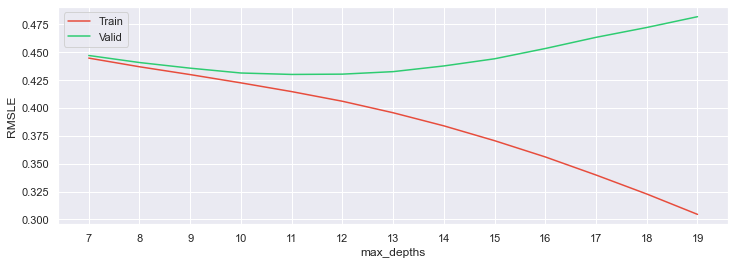

In [41]:
max_depths = range(7, 20)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
valid_scores = []
for depth in max_depths:
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    regr = DecisionTreeRegressor(max_depth = depth)
    #Обучаем модель
    regr.fit(X_train_scaled,  y_train_log)
    #Делаем предсказание для тренировочной выборки
    y_train_predict = regr.predict(X_train_scaled)
    #Делаем предсказание для тестовой выборки
    y_valid_predict = regr.predict(X_valid_scaled)
    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict)))
    
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(max_depths, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(max_depths, valid_scores, label='Valid') #линейный график для тестовой выборки
ax.set_xlabel('max_depths') #название оси абсцисс
ax.set_ylabel('RMSLE') #название оси ординат
ax.set_xticks(max_depths) #метки по оси абсцисс
ax.legend(); #отображение легенды

In [42]:
regr = DecisionTreeRegressor(max_depth = 12)
regr.fit(X_train_scaled,  y_train_log)

y_train_predict = regr.predict(X_train_scaled)
y_valid_predict = regr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

Train RMSLE score: 0.41
Test RMSLE score: 0.43


## 5. Решение задачи регрессии: ансамблевые методы и построение прогноза

Построим модель случайного леса на обучающей выборке. В качестве гиперпараметров укажим следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42


In [43]:
from sklearn.ensemble import RandomForestRegressor

RFregr = RandomForestRegressor(max_depth=12, 
                               n_estimators=200, 
                               criterion='squared_error', 
                               min_samples_split=20,
                               verbose = 1,
                               n_jobs = -1,
                               random_state=42)
RFregr.fit(X_train_scaled,  y_train_log)

y_train_predict = RFregr.predict(X_train_scaled)
y_valid_predict = RFregr.predict(X_valid_scaled)
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.3s


Train RMSLE score: 0.40
Test RMSLE score: 0.41


[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    3.7s finished


Построим модель градиентного бустинга над деревьями решений. В качестве гиперпараметров укажем следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42


In [44]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(
    max_depth=6, #максимальная глубина дерева
    learning_rate=0.5,
    n_estimators=100, #количество деревьев
    min_samples_split=30,
    verbose = 1, 
    random_state=42 #генератор случайных чисел
)
gb.fit(X_train_scaled,  y_train_log)
 
y_train_predict = gb.predict(X_train_scaled)
y_valid_predict = gb.predict(X_valid_scaled)
print('Train RMSLE  score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log,y_train_predict))))
print('Test RMSLE: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log,y_valid_predict))))

      Iter       Train Loss   Remaining Time 
         1           0.3110           15.17m
         2           0.2247           15.52m
         3           0.1987           15.46m
         4           0.1875           15.60m
         5           0.1821           15.47m
         6           0.1789           15.48m
         7           0.1742           15.62m
         8           0.1721           15.71m
         9           0.1705           15.56m
        10           0.1694           15.34m
        20           0.1585           12.71m
        30           0.1532           10.81m
        40           0.1500            9.09m
        50           0.1468            7.55m
        60           0.1439            6.05m
        70           0.1421            4.53m
        80           0.1402            3.02m
        90           0.1383            1.50m
       100           0.1371            0.00s
Train RMSLE  score: 0.37
Test RMSLE: 0.39


Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

<AxesSubplot:>

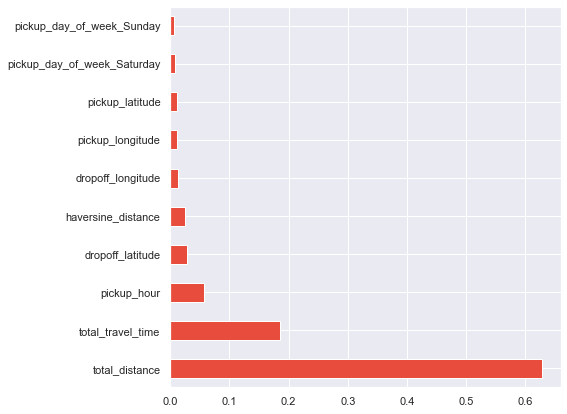

In [45]:
plt.rcParams['figure.figsize'] = (7,7)
feat_importances = pd.Series(gb.feature_importances_, index=X_train_scaled.columns)
feat_importances.nlargest(10).plot(kind='barh')

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты и округлим до десятых.


In [46]:
import math
MeAE = (metrics.median_absolute_error((math.e**(y_valid_log)-1) , (math.e**(y_valid_predict)-1))/60)
print('MeAE score: {:.2f}'.format(round(MeAE, 1)))

MeAE score: 1.80


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [47]:
test_data = pd.read_csv("test_data.csv")
osrm_data_test = pd.read_csv("osrm_data_test.csv")
test_id = test_data['id']

In [48]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)

coords = test_data[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']]
predictions = kmeans.predict(coords)
test_data['geo_cluster'] = predictions


test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_list]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


После выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Необходимо также перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

In [49]:
y_test_predict = np.exp(gb.predict(X_test_scaled)) - 1

In [50]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submission_gb.csv', index=False)

В завершение по ансамблевым мы предлагаем вам попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


In [51]:
#pip install xgboost

In [52]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [53]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_list)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_list)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_list)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [54]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[10]	train-rmse:1.93576	valid-rmse:1.93572
[20]	train-rmse:0.78510	valid-rmse:0.78595
[30]	train-rmse:0.47863	valid-rmse:0.48067
[40]	train-rmse:0.42062	valid-rmse:0.42332
[50]	train-rmse:0.40902	valid-rmse:0.41217
[60]	train-rmse:0.40392	valid-rmse:0.40740
[70]	train-rmse:0.40094	valid-rmse:0.40482
[80]	train-rmse:0.39878	valid-rmse:0.40296
[90]	train-rmse:0.39718	valid-rmse:0.40163
[100]	train-rmse:0.39565	valid-rmse:0.40033
[110]	train-rmse:0.39437	valid-rmse:0.39930
[120]	train-rmse:0.39314	valid-rmse:0.39848
[130]	train-rmse:0.39198	valid-rmse:0.39751
[140]	train-rmse:0.39085	valid-rmse:0.39687
[150]	train-rmse:0.38996	valid-rmse:0.39643
[160]	train-rmse:0.38920	valid-rmse:0.39589
[170]	train-rmse:0.38810	valid-rmse:0.39507
[180]	train-rmse:0.38727	valid-rmse:0.39451
[190]	train-rmse:0.38656	valid-rmse:0.39411
[200]	train-rmse:0.38575	valid-rmse:0.39356
[210]	train-rmse:0.38498	valid-rmse:0.39308
[220]	train-rmse:0.38442	valid-rmse:0.39283

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [55]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.2f' % model.best_score)

Modeling RMSLE 0.39


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. В библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

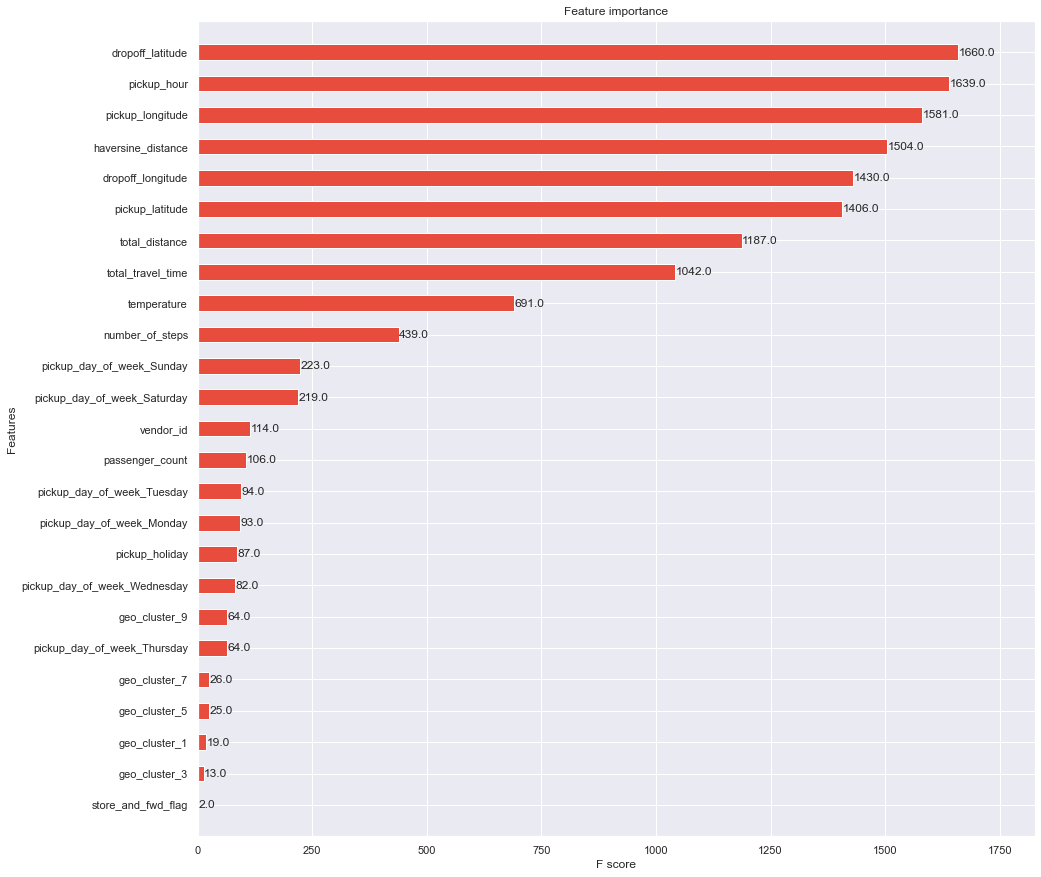

In [56]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

In [57]:
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('submission_xgb.csv', index=False)